# Run data from simulation 1 and make validation plots

Stephen Fleming

2023.06.27

Small test using a tiny simulation

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cellcap.scvi_module import CellCap
from cellcap.validation.plot import plot_adversarial_classifier_roc, plot_ard_parameters, plot_program_usage

Global seed set to 0


# Data

In [3]:
adata = sc.read_h5ad('data/simulation_data1.h5ad')
adata.layers['counts'] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 6000 × 1000
    obs: 'State', 'Pseudotime', 'Condition', 'batch'
    layers: 'counts'

In [4]:
adata.obs.head()

,State,Pseudotime,Condition,batch
0-0,A,0.000000,Control,0
1-0,A,0.000500,Control,0
2-0,A,0.001001,Control,0
3-0,A,0.001501,Control,0
4-0,A,0.002001,Control,0


In [5]:
perturbation_key = 'Condition'

## Exploration

In [6]:
pd.crosstab(adata.obs[perturbation_key], adata.obs['batch'], dropna=False, margins=True)

batch,0,1,2,All
Condition,,,,
Control,2000,0,0,2000
Perturbation1,0,2000,0,2000
Perturbation2,0,0,2000,2000
All,2000,2000,2000,6000


In [7]:
pd.crosstab(adata.obs[perturbation_key], adata.obs['State'], dropna=False, margins=True)

State,A,All
Condition,,
Control,2000,2000
Perturbation1,2000,2000
Perturbation2,2000,2000
All,6000,6000


# Model

## Setup

In [8]:
# for now we are using adata.obsm slots

assert 'control' in adata.obs[perturbation_key].str.lower().values, \
    f'adata.obs["{perturbation_key}"] does not contain "control" or "Control" '

adata.obsm['X_donor'] = pd.get_dummies(adata.obs['State']).to_numpy().astype(float)
adata.obsm['X_target'] = pd.get_dummies(
    (adata.obs[perturbation_key]
     .str.lower()
     .replace(to_replace='control', value=np.nan))
).to_numpy().astype(float)

adata

AnnData object with n_obs × n_vars = 6000 × 1000
    obs: 'State', 'Pseudotime', 'Condition', 'batch'
    obsm: 'X_donor', 'X_target'
    layers: 'counts'

In [9]:
adata.obsm['X_target'].sum(axis=0)

array([2000., 2000.])

In [10]:
adata.obs[perturbation_key].value_counts()

Condition
Control          2000
Perturbation1    2000
Perturbation2    2000
Name: count, dtype: int64

In [11]:
CellCap.setup_anndata(adata, layer='counts', target_key='X_target', donor_key='X_donor')

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [12]:
n_response_programs = 15

cellcap = CellCap(
    adata, 
    n_latent=50,  # 20, 
    n_layers=3,  # 3,
    n_drug=adata.obs[perturbation_key].nunique() - 1, 
    n_donor=adata.obs['State'].nunique(), 
    gene_likelihood='nb', 
    n_prog=n_response_programs,
)

## Train

In [13]:
cellcap.train(max_epochs=1000, batch_size=1024)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1000/1000: 100%|██████████████████████████████████████| 1000/1000 [11:24<00:00,  1.46it/s, loss=2.58e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████████████████████████████████| 1000/1000 [11:24<00:00,  1.46it/s, loss=2.58e+03, v_num=1]


# Output exploration

Get latent vector and visualization

In [14]:
import gc
gc.collect()

437

## Basal cell state

In [15]:
z = cellcap.get_latent_embedding(adata)
z.shape

(6000, 50)

In [16]:
adata.obsm['X_basal'] = z

In [17]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_basal', random_state=0, metric='cosine')
sc.tl.umap(adata, min_dist=0.15)#,method='rapids')

/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


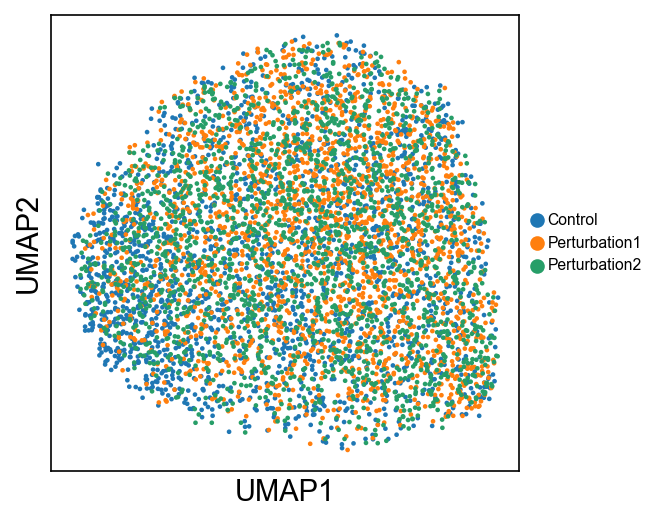

In [18]:
sc.set_figure_params(scanpy=True, dpi=75, dpi_save=75)
sc.pl.umap(adata, color='Condition', title='', legend_fontsize=7.5)

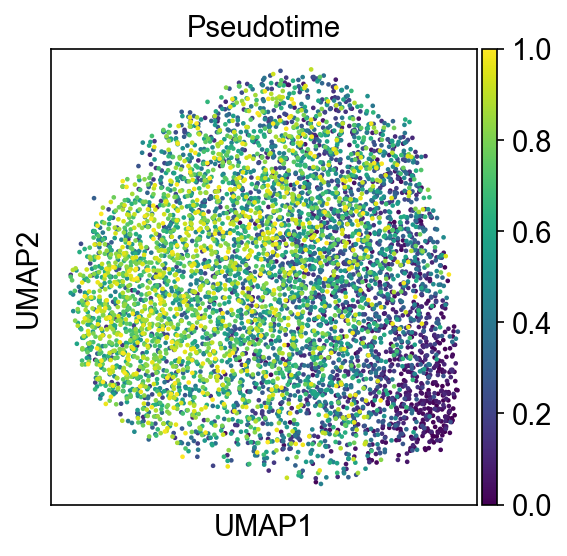

In [19]:
sc.pl.umap(adata, color='Pseudotime', legend_fontsize=7.5)

### Classifier accuracy

Want a classifier that uses the basal state to predict perturbation to be very poor.

Control (AUC = 0.7384)
Perturbation1 (AUC = 0.6175)
Perturbation2 (AUC = 0.5872)


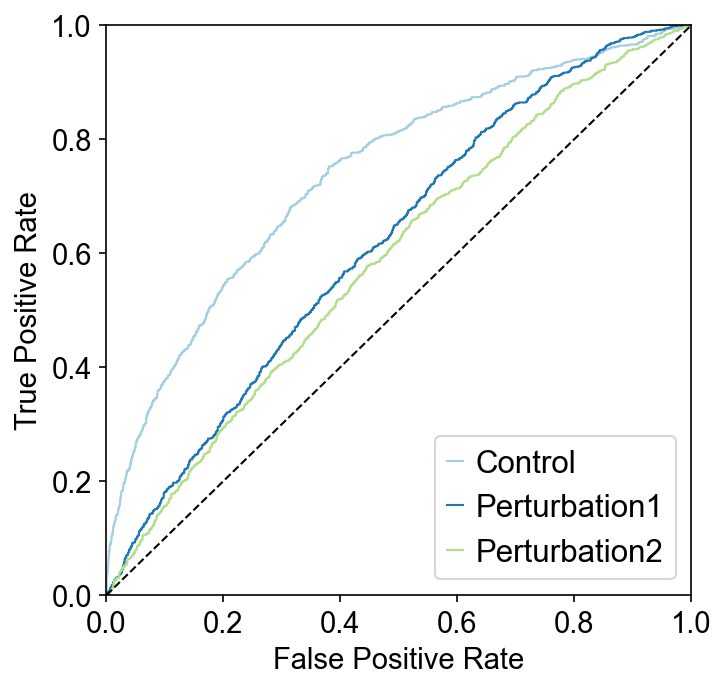

In [20]:
plot_adversarial_classifier_roc(
    adata=adata,
    perturbation_key=perturbation_key,
)

## Program usage

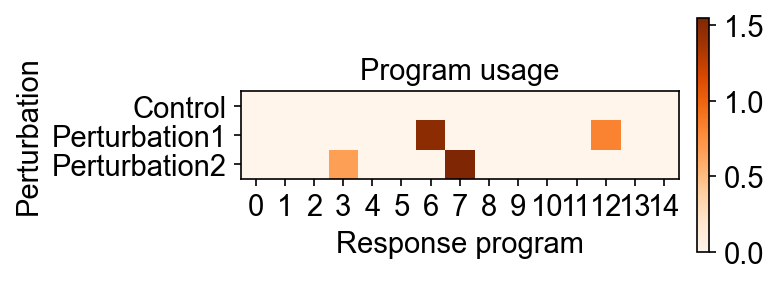

In [21]:
# how much is each program used by each perturbation?

df_usage = plot_program_usage(
    cellcap=cellcap,
    adata=adata,
    perturbation_key=perturbation_key,
)

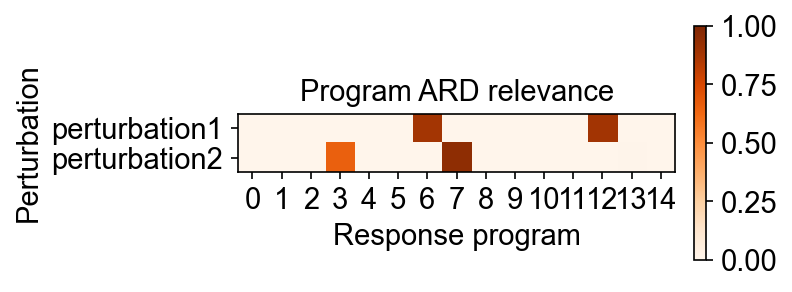

In [22]:
# which programs does ARD "turn off"?

df_ard = plot_ard_parameters(
    cellcap=cellcap,
    adata=adata,
    perturbation_key=perturbation_key,
)

## Attention maps